In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
from multiprocess import Pool
import numpy as np

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *

Setting environment for Precision WorkStation


No vtk


In [2]:
atlas_spec = dict(name='atlasV6',
                   vol_type='score'    ,               
                    resolution='10.0um'
                   )

In [3]:
atlas_structures_wrt_canonicalAtlasSpace_atlasResol = \
DataManager.load_original_volume_all_known_structures_v3(atlas_spec, in_bbox_wrt='canonicalAtlasSpace',
                                                        out_bbox_wrt='canonicalAtlasSpace')

Prior structure/index map not found. Generating a new one.


In [4]:
atlas_structure_centroids_wrt_canonicalAtlasSpace_atlasResol = get_structure_centroids(vol_origin_dict=atlas_structures_wrt_canonicalAtlasSpace_atlasResol)

In [5]:
atlas_anchor1_wrt_canonicalAtlasSpace_atlasResol = \
np.r_[atlas_structure_centroids_wrt_canonicalAtlasSpace_atlasResol['12N'][:2], 0]
atlas_anchor2_wrt_canonicalAtlasSpace_atlasResol = \
np.r_[atlas_structure_centroids_wrt_canonicalAtlasSpace_atlasResol['3N_L'][:2], 0]

In [52]:
stack = 'CHATM2'

In [53]:
if stack == 'CHATM2':
    subject_anchor1_wrt_wholebrainWithMargin_atlasResol = np.array([565,246,179]) * 20. / 10. # 12N
    subject_anchor2_wrt_wholebrainWithMargin_atlasResol = np.array([388,183,179]) * 20. / 10. # 3N_L
elif stack == 'CHATM3':
    subject_anchor1_wrt_wholebrainWithMargin_atlasResol = np.array([740,258,230]) * 20. / 10.
    subject_anchor2_wrt_wholebrainWithMargin_atlasResol = np.array([550,195,230]) * 20. / 10.

In [54]:
from registration_utilities import *

In [55]:
def align_anchors(pm1, pm2, pf1, pf2):
    
    t = ((pf1 + pf2) / 2. - (pm1 + pm2) / 2.)

    subject_d = pf1 - pf2
    atlas_d = pm1 - pm2

    subject_d_n = subject_d / np.linalg.norm(subject_d)
    atlas_d_n = atlas_d / np.linalg.norm(atlas_d)

    R = R_align_two_vectors(atlas_d_n, subject_d_n)

    T = np.zeros((3,4))
    T[:3, :3] = R
    T[:3, 3] = t
    
    return T

In [56]:
intensity_volume_spec = dict(name=stack, resolution='10.0um', prep_id='wholebrainWithMargin', vol_type='intensity')
_, wholebrainWithMargin_origin_wrt_wholebrain_dataResol = DataManager.load_original_volume_v2(intensity_volume_spec, return_origin_instead_of_bbox=True)

In [57]:
subject_anchor1_wrt_wholebrain_atlasResol = subject_anchor1_wrt_wholebrainWithMargin_atlasResol + \
wholebrainWithMargin_origin_wrt_wholebrain_dataResol # only valid because dataResol is same as atlasResol

subject_anchor2_wrt_wholebrain_atlasResol = subject_anchor2_wrt_wholebrainWithMargin_atlasResol + \
wholebrainWithMargin_origin_wrt_wholebrain_dataResol # only valid because dataResol is same as atlasResol

In [58]:
T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol = align_anchors(atlas_anchor1_wrt_canonicalAtlasSpace_atlasResol, atlas_anchor2_wrt_canonicalAtlasSpace_atlasResol,
             subject_anchor1_wrt_wholebrain_atlasResol, subject_anchor2_wrt_wholebrain_atlasResol)

In [59]:
print T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol

[[ 9.90767489e-01  1.35582009e-01  0.00000000e+00  9.22098379e+02]
 [-1.35582009e-01  9.90767489e-01  0.00000000e+00  4.50968802e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  3.58000000e+02]]


In [60]:
bp.pack_ndarray_file(T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol, '/home/yuncong/' + stack + '_T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol.bp')

In [61]:
atlas_structures_wrt_wholebrainWithMargin_atlasResol = \
{name_s: transform_volume_v4(volume=vo, transform=T_atlas_wrt_canonicalAtlasSpace_subject_wrt_wholebrain_atlasResol, return_origin_instead_of_bbox=True)
for name_s, vo in atlas_structures_wrt_canonicalAtlasSpace_atlasResol.iteritems()}

/home/yuncong/Brain/utilities/registration_utilities.py:1561: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  
Interpolating/filling sparse volume: 0.07 seconds.
Interpolating/filling sparse volume: 0.36 seconds.
Interpolating/filling sparse volume: 0.08 seconds.
Interpolating/filling sparse volume: 0.06 seconds.
Interpolating/filling sparse volume: 0.02 seconds.
Interpolating/filling sparse volume: 0.13 seconds.
Interpolating/filling sparse volume: 0.13 seconds.
Interpolating/filling sparse volume: 0.06 seconds.
Interpolating/filling sparse volume: 0.02 seconds.
Interpolating/filling sparse volume: 0.22 seconds.
Interpolating/filling sparse volume: 0.37 seconds.
Interpolating/filling sparse volume: 0.09 seconds.
Interpolating/filling sparse volume: 0.07 seconds.
Interpolating/filling sparse volume: 0.14 seconds.
Interpolating/filling sparse volume: 0.27 

In [62]:
atlas_structures_bbox_wrt_wholebrainWithMargin_atlasResol = \
{name_s: (o[0], o[0] + v.shape[1] - 1, o[1], o[1] + v.shape[0] - 1, o[2], o[2] + v.shape[2] - 1)
 for name_s, (v, o) in atlas_structures_wrt_wholebrainWithMargin_atlasResol.iteritems()}

In [63]:
# int(np.round(metadata_cache['section_limits'][stack].mean()))

In [64]:
converter = CoordinatesConverter(stack=stack)

In [65]:
intensity_volume_spec = dict(name=stack, resolution='10.0um', prep_id='wholebrainWithMargin', vol_type='intensity')
_, thumbnail_volume_origin_wrt_wholebrain_dataResol = DataManager.load_original_volume_v2(intensity_volume_spec, return_origin_instead_of_bbox=True)

In [66]:
converter.derive_three_view_frames(base_frame_name='wholebrainWithMargin', 
                                   origin_wrt_wholebrain_um=thumbnail_volume_origin_wrt_wholebrain_dataResol)

In [67]:
converter.register_new_resolution('image', convert_resolution_string_to_um(resolution='raw', stack=stack))

In [68]:
atlas_structures_wrt_wholebrainWithMargin_section_limits = {}

for name_s, b in atlas_structures_bbox_wrt_wholebrainWithMargin_atlasResol.iteritems():
#     print name_s
    atlas_structures_wrt_wholebrainWithMargin_section_limits[name_s] = \
    converter.convert_frame_and_resolution(p=[[np.nan, np.nan, b[4]], [np.nan, np.nan, b[5]]], 
                                       in_wrt=('wholebrainWithMargin', 'sagittal'),
                                      in_resolution='10.0um',
                                      out_wrt='wholebrain',
                                      out_resolution='image_image_section')[:,2].astype(np.int)

In [69]:
save_json(atlas_structures_wrt_wholebrainWithMargin_section_limits, '/home/yuncong/' + stack + '_structure_section_limits.json')

In [70]:
motor_nuclei = ['Amb', '3N', '4N', '5N', '6N', '7N', '10N', '12N']

In [71]:
detector_id = 799
output_resolution = '10.0um'

In [72]:
# for stack in ['CHATM3']:
    
atlas_structures_wrt_wholebrainWithMargin_section_limits = load_json('/home/yuncong/' + stack + '_structure_section_limits.json')

#     atlas_structures_wrt_wholebrainWithMargin_sections = defaultdict(list)
#     for name_s, (s1, s2) in atlas_structures_wrt_wholebrainWithMargin_section_limits.iteritems():
#         atlas_structures_wrt_wholebrainWithMargin_sections[convert_to_original_name(name_s)] += range(max(s1 - 10, metadata_cache['section_limits'][stack][0]), 
#                                                                                                       min(s2+1 + 10, metadata_cache['section_limits'][stack][1]))
#     atlas_structures_wrt_wholebrainWithMargin_sections = {name_s: sorted(set(sec_list)) for name_s, sec_list in atlas_structures_wrt_wholebrainWithMargin_sections.iteritems()}

# Specify isotropic resolution of the output volume.
out_resolution_um = convert_resolution_string_to_um(resolution=output_resolution, stack=stack)

# for structure in ['7N']:
for structure in motor_nuclei:


    for name_s in [convert_to_left_name(structure), convert_to_right_name(structure)]:
        
        scoremaps = {}

#         for sec in metadata_cache['valid_sections'][stack]:

        s1, s2 = atlas_structures_wrt_wholebrainWithMargin_section_limits[name_s]

        for sec in range(max(s1 - 10, metadata_cache['section_limits'][stack][0]), 
                         min(s2+1 + 10, metadata_cache['section_limits'][stack][1])):

            if is_invalid(sec=sec, stack=stack):
                continue

            scoremap = DataManager.load_downscaled_scoremap(stack=stack, section=sec, structure=structure, 
                                                            prep_id='alignedBrainstemCrop',
                                                          out_resolution_um=out_resolution_um, 
                                                            detector_id=detector_id).astype(np.float32)

            mask = DataManager.load_image_v2(stack=stack, section=sec, 
                                 prep_id='alignedBrainstemCrop', 
                                 resol='thumbnail', version='mask')

            mask_outResol = rescale_by_resampling(mask, new_shape=(scoremap.shape[1], scoremap.shape[0]))

            scoremap[~mask_outResol] = 0
            scoremaps[sec] = scoremap

        volume_outVolResol, volume_origin_wrt_wholebrainXYcropped_outVolResol = \
        images_to_volume_v2(images=scoremaps, spacing_um=20.,
                                in_resol_um=out_resolution_um,
                                out_resol_um=out_resolution_um)
        print volume_outVolResol.shape

        brain_spec = dict(name=stack,
                       vol_type='score',
                        detector_id=detector_id,
                       resolution=output_resolution)

        # Save volume and origin.

        save_data(volume_outVolResol.astype(np.float16), \
                  DataManager.get_original_volume_filepath_v2(stack_spec=brain_spec, structure=name_s))

        wholebrainXYcropped_origin_wrt_wholebrain_outVolResol = \
        DataManager.get_domain_origin(stack=stack, domain='wholebrainXYcropped', 
                                      resolution=output_resolution)
        volume_origin_wrt_wholebrain_outVolResol =\
        volume_origin_wrt_wholebrainXYcropped_outVolResol + wholebrainXYcropped_origin_wrt_wholebrain_outVolResol

        save_data(volume_origin_wrt_wholebrain_outVolResol,
                  DataManager.get_original_volume_origin_filepath_v3(stack_spec=brain_spec, structure=name_s, wrt='wholebrain'))

        # Compute gradients.

        gradients = compute_gradient_v2((volume_outVolResol, volume_origin_wrt_wholebrain_outVolResol), 
                                        smooth_first=True)

        DataManager.save_volume_gradients(gradients, stack_spec=brain_spec, structure=name_s)

Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide36_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide35_2018_01_20-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide36_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide36_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide37_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide38_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide37_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide38_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide37_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide38_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide39_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide39_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide39_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide41_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide42_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide41_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide42_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide41_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide42_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide44_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide44_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_prep2_thumbnail_mask.png
(590, 872, 57)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_Amb_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_Amb_L.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_Amb_L_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_Amb_L_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide78_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide78_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide78_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide80_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide80_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide80_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide82_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide82_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide82_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide84_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide84_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide84_2018_02_14-S3_prep2_thumbnail_mask.png
(576, 917, 55)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_Amb_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_Amb_R.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_Amb_R_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_Amb_R_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep2_thumbnail_mask.png
(588, 917, 71)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_3N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_3N_L.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_3N_L_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_3N_L_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_prep2_thumbnail_mask.png
(585, 917, 69)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_3N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_3N_R.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_3N_R_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_3N_R_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep2_thumbnail_mask.png
(588, 917, 45)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_4N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_4N_L.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_4N_L_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_4N_L_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_prep2_thumbnail_mask.png
(588, 917, 43)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_4N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_4N_R.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_4N_R_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_4N_R_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_10.0um_scoreVolume_4N_R_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scor

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide30_2018_01_18-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide29_2018_01_18-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide30_2018_01_18-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide32_2018_01_20-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide31_2018_01_19-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide32_2018_01_20-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide31_2018_01_19-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide32_2018_01_20-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide33_2018_01_20-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide34_2018_01_20-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide33_2018_01_20-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide34_2018_01_20-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide33_2018_01_20-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide34_2018_01_20-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide35_2018_01_20-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide36_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide35_2018_01_20-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide36_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide36_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide37_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide38_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide37_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide38_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide37_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide38_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide39_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide39_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide39_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide41_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide42_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide41_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide42_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide41_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide42_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide44_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide44_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide44_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide45_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide46_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide45_2018_01_22-S2_prep2_thumbnail_mask.png
(590, 905, 101)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_5N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_5N_L.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_5N_L_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_5N_L_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_10.0um_scoreVolume_5N_L_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_sco

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide76_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide76_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide78_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide78_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide78_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide80_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide80_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide80_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide82_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide82_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide82_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide84_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide84_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide84_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide86_2018_02_13-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide86_2018_02_13-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide86_2018_02_13-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide88_2018_02_13-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide88_2018_02_13-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide88_2018_02_13-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide90_2018_02_13-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide90_2018_02_13-S2_prep2_thumbnail_mask.png


Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide90_2018_02_13-S3_prep2_thumbnail_mask.png
(576, 917, 99)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_5N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_5N_R.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_5N_R_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_5N_R_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_10.0um_scoreVolume_5N_R_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scor

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide49_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide50_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide50_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep2_thumbnail_mask.png
(588, 917, 59)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_6N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_6N_L.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_6N_L_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_6N_L_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_prep2_thumbnail_mask.png
(590, 917, 59)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_6N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_6N_R.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_6N_R_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_6N_R_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide30_2018_01_18-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide32_2018_01_20-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide31_2018_01_19-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide32_2018_01_20-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide31_2018_01_19-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide32_2018_01_20-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide33_2018_01_20-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide34_2018_01_20-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide33_2018_01_20-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide34_2018_01_20-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide33_2018_01_20-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide34_2018_01_20-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide35_2018_01_20-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide36_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide35_2018_01_20-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide36_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide36_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide37_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide38_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide37_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide38_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide37_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide38_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide39_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide39_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide39_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide41_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide42_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide41_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide42_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide41_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide42_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide44_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide44_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide43_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide44_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide45_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide46_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide45_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide46_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide45_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide46_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide48_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide48_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide48_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide49_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide50_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide49_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide50_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide50_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_prep2_thumbnail_mask.png
(590, 917, 137)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_7N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_7N_L.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_7N_L_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_7N_L_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_10.0um_scoreVolume_7N_L_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_sco

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide72_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide72_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide72_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide74_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide74_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide74_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide76_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide76_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide76_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide78_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide78_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide78_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide80_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide80_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide80_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide82_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide82_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide82_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide84_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide84_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide84_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide86_2018_02_13-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide86_2018_02_13-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide86_2018_02_13-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide88_2018_02_13-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide88_2018_02_13-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide88_2018_02_13-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide90_2018_02_13-S1_prep2_thumbnail_mask.png


Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide90_2018_02_13-S2_prep2_thumbnail_mask.png
(590, 917, 135)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_7N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_7N_R.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_7N_R_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_7N_R_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_10.0um_scoreVolume_7N_R_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_sco

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide49_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide50_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide49_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide50_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide50_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_prep2_thumbnail_mask.png
(588, 917, 93)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_10N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_10N_L.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_10N_L_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_10N_L_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide72_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide72_2018_02_14-S2_prep2_thumbnail_mask.png
(585, 917, 95)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_10N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_10N_R.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_10N_R_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_10N_R_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_10.0um_scoreVolume_10N_R_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_prep2_thumbnail_mask.png
(590, 917, 125)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_12N.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_12N.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_12N_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_12N_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_10.0um_scoreVolume_12N_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVol

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide51_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide52_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide53_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide54_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide55_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide56_2018_01_22-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide58_2018_01_22-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide57_2018_01_22-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide62_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S2_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide64_2018_02_15-S3_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S1_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S2_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide66_2018_02_14-S3_prep2_thumbnail_mask.png


Not using image_cache.
Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S1_prep2_thumbnail_mask.png
/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide68_2018_02_14-S2_prep2_thumbnail_mask.png


Not using image_cache.


/data/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_mask/CHATM2_slide70_2018_02_14-S1_prep2_thumbnail_mask.png
(590, 917, 125)
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_12N.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_12N.bp"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_12N_origin_wrt_wholebrain.txt" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volumes/CHATM2_detector799_10.0um_scoreVolume_12N_origin_wrt_wholebrain.txt"
0
aws s3 cp "/home/yuncong/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVolume/score_volume_gradients/CHATM2_detector799_10.0um_scoreVolume_12N_gradients.bp" "s3://mousebrainatlas-data/CSHL_volumes/CHATM2/CHATM2_detector799_10.0um_scoreVol

In [27]:
brain_spec = dict(name=stack,
               vol_type='score',
                detector_id=detector_id,
               resolution=output_resolution)

In [41]:
vo = DataManager.load_original_volume_v2(brain_spec, structure='7N_R')

In [45]:
vo = DataManager.load_original_volume_v2(brain_spec, structure='7N_L')

In [46]:
vo[1]

array([934.76, 107.92, 276.  ])

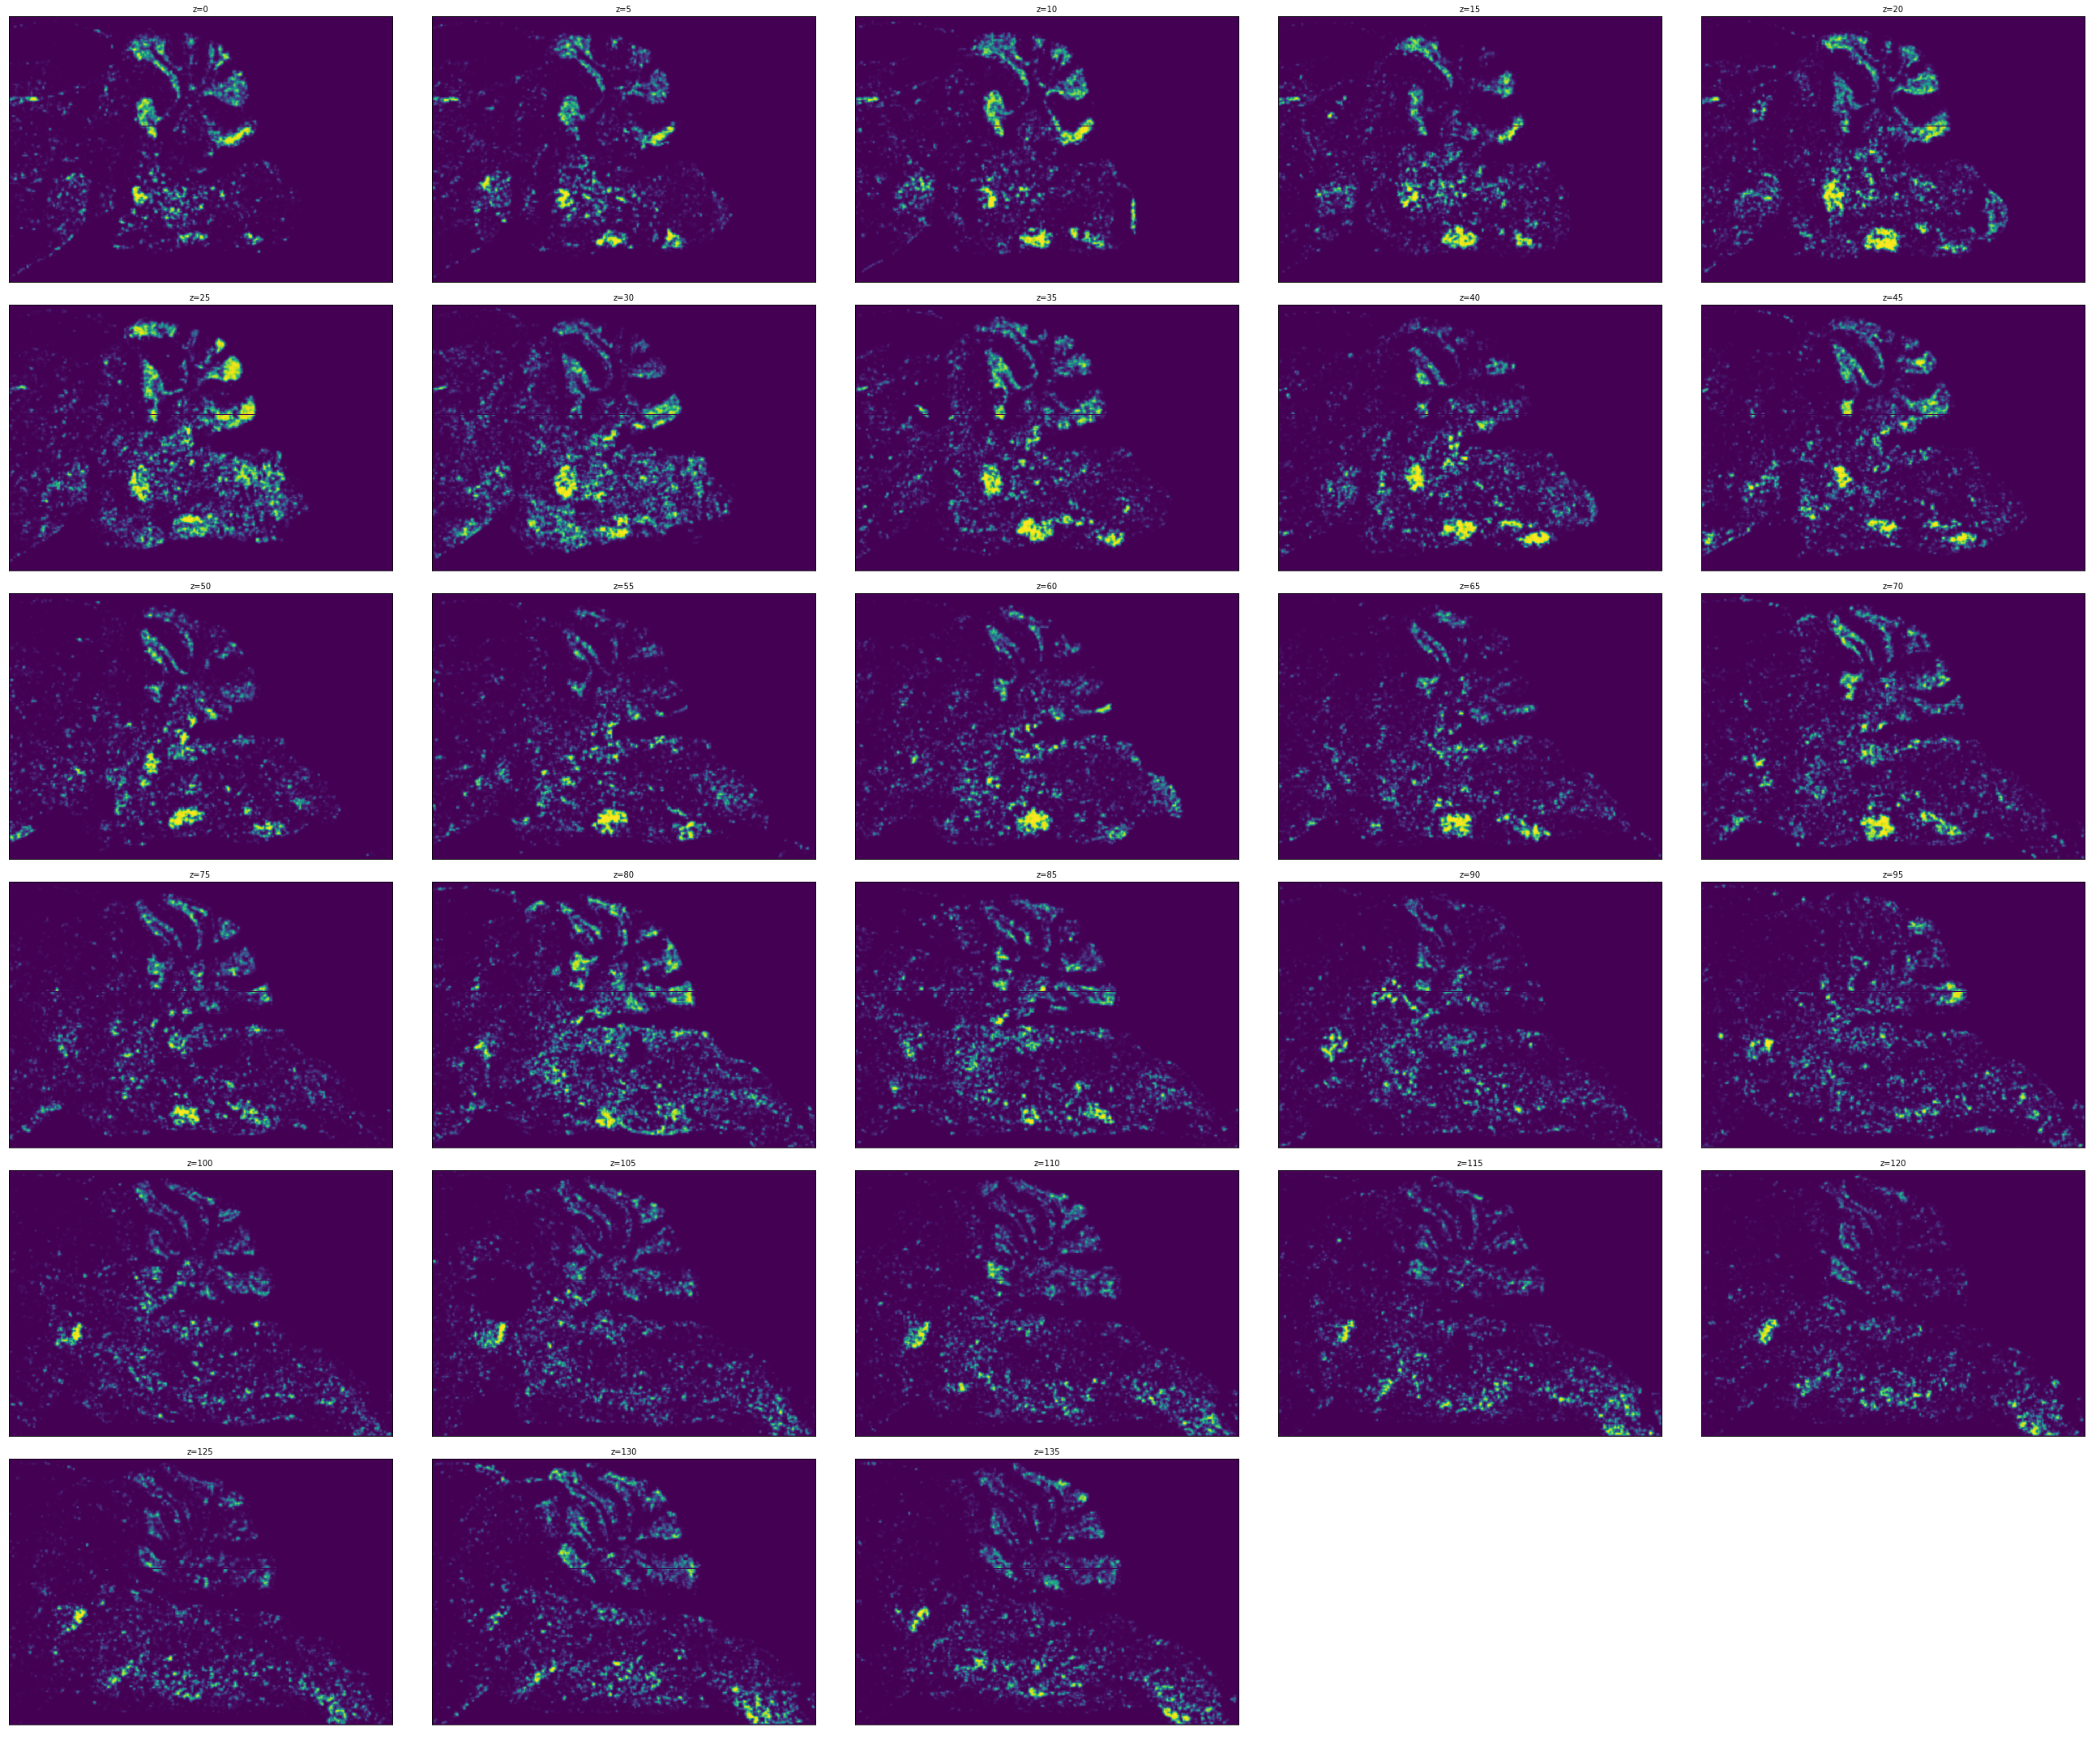

In [47]:
display_volume_sections(vo[0], start_level=0)